In [1]:
import os
import glob

import pandas as pd
import numpy as np
import ydata_profiling
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt

from library.sb_utils import save_file

There are two data sources:

- Electric usage data from PG&E
- Weather data from NCEI Climate Data

# Electric usage data

## Loading the data

**PG&E Electric Usage by Zipcode**

Info on this dataset from PG&E (https://pge-energydatarequest.com/public_datasets/download?type=electric):

Customer usage data, both for gas (therms) and electric (kWh) usage, is reported by ZIP code, by month, by year, and by the four customer types – residential, commercial, agricultural and industrial. The reports on this data are made available pursuant to California Public Utilities Commission Decision 14-05-016 (view the Decision here). Accordingly, the public datasets meet Commission Decision rules for public aggregation of data, as follows: a minimum of 100 Residential customers; a minimum of 15 Non-Residential customers, with no single Non-Residential customer accounting for more than 15% of the total consumption. If aggregation is not met, the consumption will be combined with a neighboring ZIP code until the aggregation requirements are met.

Let's examine one file:

In [2]:
#load data file for a single quarter of electric usage
df = pd.read_csv('data/PGE_ElectricUsageByZip/PGE_2013_Q1_ElectricUsageByZip.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7521 entries, 0 to 7520
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   ZipCode         7521 non-null   int64 
 1   Month           7521 non-null   int64 
 2   Year            7521 non-null   int64 
 3   CustomerClass   7521 non-null   object
 4   Combined        7521 non-null   object
 5   TotalCustomers  7521 non-null   object
 6   TotalkWh        7521 non-null   object
 7   AveragekWh      3172 non-null   object
dtypes: int64(3), object(5)
memory usage: 470.2+ KB


In [4]:
df.head()

ZipCode  Month  Year       CustomerClass Combined TotalCustomers TotalkWh  \
0    93202      1  2013  Elec- Agricultural        Y              0        0   
1    93202      2  2013  Elec- Agricultural        Y              0        0   
2    93202      3  2013  Elec- Agricultural        Y              0        0   
3    93203      1  2013  Elec- Agricultural        Y              0        0   
4    93203      2  2013  Elec- Agricultural        Y              0        0   

  AveragekWh  
0        NaN  
1        NaN  
2        NaN  
3        NaN  
4        NaN

The data comes in quarterly files. We need to concatenate them into a single DataFrame.

Column naming is inconsistent between quarterly files. Some have all uppercase column names, some have mixed case. We will to correct this by renaming columns.

In [5]:
#load and concatenate all data files for electric usage
electric_usage = pd.DataFrame()

files = glob.glob('data/PGE_ElectricUsageByZip/*.csv')

colmap = dict(zip(list(df.columns.str.upper()), list(df.columns)))

for file in files:
    df = pd.read_csv(file)
    # column names change case partway through the dataset
    df.rename(columns=colmap, inplace=True)
    electric_usage = pd.concat([electric_usage, df], ignore_index=True)

In [6]:
electric_usage.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 357444 entries, 0 to 357443
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   ZipCode         357444 non-null  int64 
 1   Month           357444 non-null  int64 
 2   Year            357444 non-null  int64 
 3   CustomerClass   357444 non-null  object
 4   Combined        357444 non-null  object
 5   TotalCustomers  357444 non-null  object
 6   TotalkWh        357444 non-null  object
 7   AveragekWh      161885 non-null  object
dtypes: int64(3), object(5)
memory usage: 21.8+ MB


In [7]:
electric_usage.head()

ZipCode  Month  Year       CustomerClass Combined TotalCustomers TotalkWh  \
0    93101      7  2021  Elec- Agricultural        Y              0        0   
1    93101      8  2021  Elec- Agricultural        Y              0        0   
2    93101      9  2021  Elec- Agricultural        Y              0        0   
3    93110      7  2021  Elec- Agricultural        Y              0        0   
4    93110      8  2021  Elec- Agricultural        Y              0        0   

  AveragekWh  
0        NaN  
1        NaN  
2        NaN  
3        NaN  
4        NaN

## Exploration of data types

The following columns should be changed to categorical:
- ZipCode
- CustomerClass
- Combined

The following columns should be changed to numeric:
- TotalCustomers
- TotalkWh
- AveragekWh

In [8]:
# cast columns as appropriate data types

electric_usage['ZipCode'] = electric_usage['ZipCode'].astype('category')
electric_usage['CustomerClass'] = electric_usage['CustomerClass'].astype('category')
electric_usage['Combined'] = electric_usage['Combined'].astype('category')

electric_usage['TotalCustomers'] = pd.to_numeric(electric_usage['TotalCustomers'].str.replace(',',''))
electric_usage['TotalkWh'] = pd.to_numeric(electric_usage['TotalkWh'].str.replace(',',''))
electric_usage['AveragekWh'] = pd.to_numeric(electric_usage['AveragekWh'].str.replace(',',''))



Let's create a more useful date columns:

In [9]:
electric_usage['Day'] = 1
electric_usage['Date'] = pd.to_datetime(electric_usage[['Year', 'Month', 'Day']])
electric_usage['DateMY'] = electric_usage['Date'].dt.strftime('%Y-%m')

In [10]:
electric_usage.head()

ZipCode  Month  Year       CustomerClass Combined  TotalCustomers  TotalkWh  \
0   93101      7  2021  Elec- Agricultural        Y               0         0   
1   93101      8  2021  Elec- Agricultural        Y               0         0   
2   93101      9  2021  Elec- Agricultural        Y               0         0   
3   93110      7  2021  Elec- Agricultural        Y               0         0   
4   93110      8  2021  Elec- Agricultural        Y               0         0   

   AveragekWh  Day       Date   DateMY  
0         NaN    1 2021-07-01  2021-07  
1         NaN    1 2021-08-01  2021-08  
2         NaN    1 2021-09-01  2021-09  
3         NaN    1 2021-07-01  2021-07  
4         NaN    1 2021-08-01  2021-08

In [11]:
electric_usage.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 357444 entries, 0 to 357443
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   ZipCode         357444 non-null  category      
 1   Month           357444 non-null  int64         
 2   Year            357444 non-null  int64         
 3   CustomerClass   357444 non-null  category      
 4   Combined        357444 non-null  category      
 5   TotalCustomers  357444 non-null  int64         
 6   TotalkWh        357444 non-null  int64         
 7   AveragekWh      161885 non-null  float64       
 8   Day             357444 non-null  int64         
 9   Date            357444 non-null  datetime64[ns]
 10  DateMY          357444 non-null  object        
dtypes: category(3), datetime64[ns](1), float64(1), int64(5), object(1)
memory usage: 23.2+ MB


## Duplicates and missing values

Let's look for duplicates:

In [12]:
# Explore duplicates
duplicates = electric_usage.duplicated()
sum(duplicates)

14863

There are many duplicates. Some quarterly data files cover more than one quarter of data. Drop the duplicates:

In [13]:
electric_usage.drop_duplicates(inplace=True)

Next, we generate a profile report using ydata_profiling to examine counts, ranges, uniques, and missing values for each variable in our category of choice, residential customers.

In [14]:
report_residential = electric_usage.loc[electric_usage['CustomerClass'] == 'Elec- Residential'].profile_report(sort=None, html={'style':{'full_width': True}}, progress_bar=False)
# report_residential.to_widgets() # run this to convert the report to a widget
report_residential

We see above that 8.8% of our target values (AveragekWh) are missing. This could be due to zip codes that are primarily commercial, industrial, or agricultural, and therefore do not have any residential customers. In addition, some zip codes with a small number of customers have been merged with neighboring zip codes in order to preserve customer privacy. Let's downselect to only residential customers, then remove all zip codes that have missing data:

In [15]:
electric_res = electric_usage.loc[electric_usage['CustomerClass'] == 'Elec- Residential']
zips_to_drop = electric_res['ZipCode'].loc[electric_res['AveragekWh'].isnull()].unique()
electric_res = electric_res[~electric_res['ZipCode'].isin(zips_to_drop)]
electric_res.reset_index(drop=True, inplace=True)

In [16]:
len(electric_res['ZipCode'].unique())

727

We went from 876 unique zip codes to 727, dropping 149 zip codes with missing residential usage data.

In [17]:
report_residential2 = electric_res.profile_report(sort=None, html={'style':{'full_width': True}}, progress_bar=False)
#report_residential2.to_widgets() # run this to convert the report to a widget
report_residential2

## Reviewing and saving the data

In [18]:
# final wrangled electric data
electric_res.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99477 entries, 0 to 99476
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   ZipCode         99477 non-null  category      
 1   Month           99477 non-null  int64         
 2   Year            99477 non-null  int64         
 3   CustomerClass   99477 non-null  category      
 4   Combined        99477 non-null  category      
 5   TotalCustomers  99477 non-null  int64         
 6   TotalkWh        99477 non-null  int64         
 7   AveragekWh      99477 non-null  float64       
 8   Day             99477 non-null  int64         
 9   Date            99477 non-null  datetime64[ns]
 10  DateMY          99477 non-null  object        
dtypes: category(3), datetime64[ns](1), float64(1), int64(5), object(1)
memory usage: 6.5+ MB


Let's look at average usage over time for all zip codes, and for two specific zip codes:

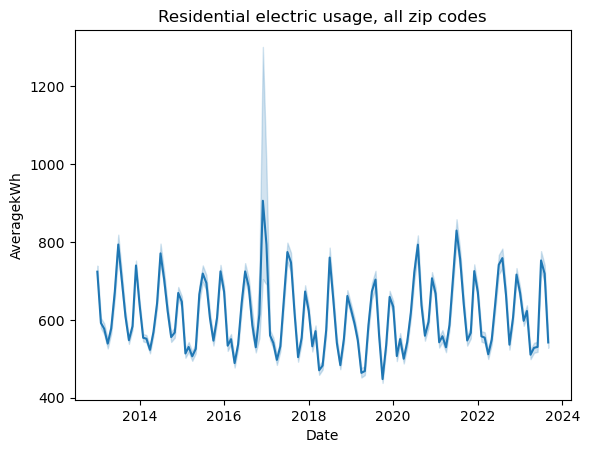

In [19]:
sns.lineplot(data=electric_res, x='Date', y='AveragekWh')
plt.title('Residential electric usage, all zip codes')
plt.show()

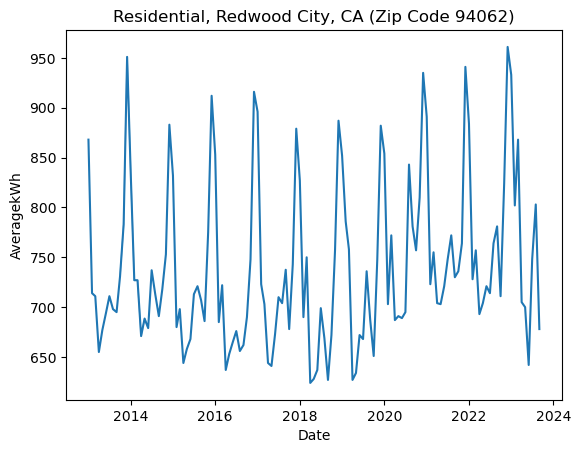

In [20]:
sns.lineplot(data=electric_res.loc[electric_res['ZipCode'] == 94062], x='Date', y='AveragekWh')
plt.title('Residential, Redwood City, CA (Zip Code 94062)')

plt.show()

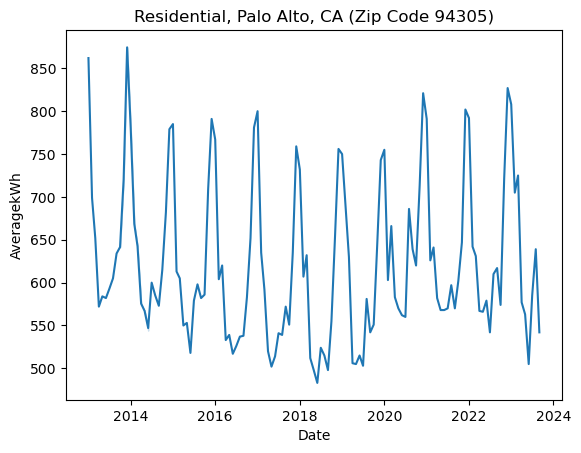

In [21]:
sns.lineplot(data=electric_res.loc[electric_res['ZipCode'] == 94305], x='Date', y='AveragekWh')
plt.title('Residential, Palo Alto, CA (Zip Code 94305)')

plt.show()

The individual zip code data looks clean. The all zip codes plot shows an anomalous spike in usage around 2017. We will examine this more in EDA.

In [22]:
# store and save the data

%store electric_res

datapath = './data'
save_file(electric_res, 'electric_res.csv', datapath)

Stored 'electric_res' (DataFrame)
Writing file.  "./data/electric_res2.csv"


# Weather data - Bulk file

## Loading the data

NCEI Climate Data bulk downloads - https://www.ncei.noaa.gov/pub/data/ghcn/daily/

Data reference docs: 

./data/readme.txt

./data/readme_by_station.txt

./data/ghcnd-stations.txt

Station of interest:

Redwood City, CA, 94062 station ID: USC00047339

Temperature format: integer, in 0.1 degrees C

In [27]:
columns = ['ID', 'DATE', 'ELEMENT', 'DATA VALUE', 'M-FLAG', 'Q-FLAG', 'S-FLAG', 'OBS-TIME']
df_w = pd.read_csv('data/GHCN/USC00047339.csv', names=columns, parse_dates=[1])

/var/folders/v5/lm06n0rd7719lt2t23hxfg600000gn/T/ipykernel_67903/536635528.py:2: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df_w = pd.read_csv('data/GHCN/USC00047339.csv', names=columns, parse_dates=[1])


In [28]:
df_w.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 172216 entries, 0 to 172215
Data columns (total 8 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   ID          172216 non-null  object        
 1   DATE        172216 non-null  datetime64[ns]
 2   ELEMENT     172216 non-null  object        
 3   DATA VALUE  172216 non-null  int64         
 4   M-FLAG      33321 non-null   object        
 5   Q-FLAG      519 non-null     object        
 6   S-FLAG      172216 non-null  object        
 7   OBS-TIME    122660 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 10.5+ MB


In [29]:
df_w.head()

ID       DATE ELEMENT  DATA VALUE M-FLAG Q-FLAG S-FLAG  OBS-TIME
0  USC00047339 1906-04-01    PRCP          38    NaN    NaN      6       NaN
1  USC00047339 1906-04-02    PRCP          15    NaN    NaN      6       NaN
2  USC00047339 1906-04-03    PRCP           0      P    NaN      6       NaN
3  USC00047339 1906-04-04    PRCP           0      P    NaN      6       NaN
4  USC00047339 1906-04-05    PRCP           0      P    NaN      6       NaN

This dataframe is not tidy. Let's pivot on the 'ELEMENT' column to create columns for each data feature.

In [30]:
df_weather = df_w.pivot(columns='ELEMENT', index='DATE', values=['DATA VALUE'])
df_weather.head()

DATA VALUE                                                          \
ELEMENT          DAPR MDPR  PRCP SNOW SNWD TMAX TMIN TOBS WT01 WT03 WT05 WT11   
DATE                                                                            
1906-04-01        NaN  NaN  38.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
1906-04-02        NaN  NaN  15.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
1906-04-03        NaN  NaN   0.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
1906-04-04        NaN  NaN   0.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
1906-04-05        NaN  NaN   0.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   

                      
ELEMENT    WT14 WT16  
DATE                  
1906-04-01  NaN  1.0  
1906-04-02  NaN  NaN  
1906-04-03  NaN  NaN  
1906-04-04  NaN  NaN  
1906-04-05  NaN  NaN

In [31]:
df_weather.columns

MultiIndex([('DATA VALUE', 'DAPR'),
            ('DATA VALUE', 'MDPR'),
            ('DATA VALUE', 'PRCP'),
            ('DATA VALUE', 'SNOW'),
            ('DATA VALUE', 'SNWD'),
            ('DATA VALUE', 'TMAX'),
            ('DATA VALUE', 'TMIN'),
            ('DATA VALUE', 'TOBS'),
            ('DATA VALUE', 'WT01'),
            ('DATA VALUE', 'WT03'),
            ('DATA VALUE', 'WT05'),
            ('DATA VALUE', 'WT11'),
            ('DATA VALUE', 'WT14'),
            ('DATA VALUE', 'WT16')],
           names=[None, 'ELEMENT'])

Let's get rid of the MultiIndex:

In [32]:
column_names =  [x[1] for x in df_weather.columns]

In [33]:
df_weather.columns = column_names

In [34]:
df_weather.head()

DAPR  MDPR  PRCP  SNOW  SNWD  TMAX  TMIN  TOBS  WT01  WT03  WT05  \
DATE                                                                           
1906-04-01   NaN   NaN  38.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
1906-04-02   NaN   NaN  15.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
1906-04-03   NaN   NaN   0.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
1906-04-04   NaN   NaN   0.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
1906-04-05   NaN   NaN   0.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   

            WT11  WT14  WT16  
DATE                          
1906-04-01   NaN   NaN   1.0  
1906-04-02   NaN   NaN   NaN  
1906-04-03   NaN   NaN   NaN  
1906-04-04   NaN   NaN   NaN  
1906-04-05   NaN   NaN   NaN

Let's subset the data to only include the date range for which we have electric data, and select only the TMIN and TMAX columns. Let's also divide by 10 to convert to degrees C.

In [93]:
weather_94062 = df_weather['2013-01-01':'2023-09-30'][['TMAX', 'TMIN']]/10

In [94]:
weather_94062.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3923 entries, 2013-01-01 to 2023-09-30
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   TMAX    3919 non-null   float64
 1   TMIN    3914 non-null   float64
dtypes: float64(2)
memory usage: 91.9 KB


## Exploration of data types

All columns are numerical, as they should be. The index is a DateTimeIndex, as it should be. No changes needed.

## Duplicates and missing values

In [95]:
# Explore duplicates
duplicates_w = weather_94062.duplicated()
sum(duplicates_w)

2949

We don't need to worry about duplicates in TMAX and TMIN, as many dates will likely have the same temperature.

Let's look for missing values:

In [96]:
weather_94062.isnull().values.any()

True

In [97]:
weather_94062['TMAX'].loc[weather_94062['TMAX'].isnull()]

DATE
2013-10-18   NaN
2013-12-04   NaN
2013-12-10   NaN
2014-02-11   NaN
Name: TMAX, dtype: float64

In [98]:
weather_94062['TMIN'].loc[weather_94062['TMIN'].isnull()]

DATE
2013-07-30   NaN
2013-08-21   NaN
2013-08-22   NaN
2013-11-12   NaN
2016-07-11   NaN
2021-07-21   NaN
2021-07-22   NaN
2023-04-09   NaN
2023-04-10   NaN
Name: TMIN, dtype: float64

There are 4 missing values for TMAX.

There are 9 missing values for TMIN.

Let's fill in missing values with their nearest neighbors:

In [99]:
weather_94062.interpolate('nearest', inplace=True)

In [100]:
weather_94062.isnull().values.any()

False

In [101]:
report_weather = weather_94062.profile_report(sort=None, html={'style':{'full_width': True}}, progress_bar=False)
report_weather

## Reviewing and saving the data

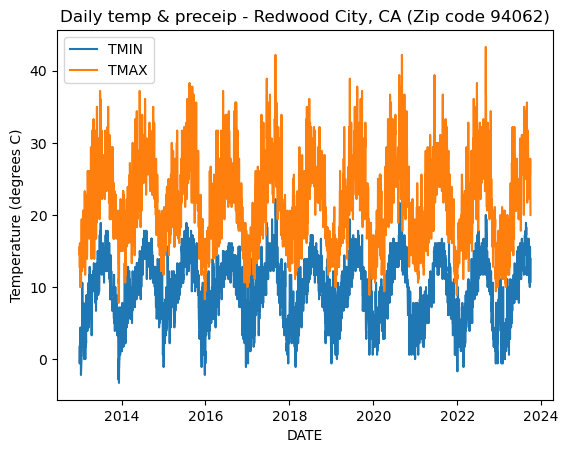

In [102]:
sns.lineplot(data=weather_94062, hue_order=['TMIN','TMAX'], dashes=False)
plt.title('Daily temp & preceip - Redwood City, CA (Zip code 94062)')
plt.ylabel('Temperature (degrees C)')
plt.show()

In [103]:
weather_94062.head()

TMAX  TMIN
DATE                  
2013-01-01  12.8   1.7
2013-01-02  15.6  -0.6
2013-01-03  14.4   0.0
2013-01-04  16.1   1.7
2013-01-05  12.2   2.2

In [104]:
weather_94062.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3923 entries, 2013-01-01 to 2023-09-30
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   TMAX    3923 non-null   float64
 1   TMIN    3923 non-null   float64
dtypes: float64(2)
memory usage: 91.9 KB


In [105]:
# store and save the data

%store weather_94062

datapath = './data'
save_file(weather_94062, 'weather_94062.csv', datapath)

Stored 'weather_94062' (DataFrame)
Writing file.  "./data/weather_94062.csv"


## Weather data - API

Note: Using bulk data import instead, but leaving this here for possible future use.

NOAA Climate Data Online API

API reference: https://www.ncdc.noaa.gov/cdo-web/webservices/v2#gettingStarted

Rate limits:
- 5 requests/sec
- 10,000 requests/day

Limit on records per request: 1000, default is 25
Use 'limit' parameter to set max requests returned.
Use 'offset' parameter to offset the resultlist

In [134]:
import requests

urlbase = "https://www.ncei.noaa.gov/cdo-web/api/v2/"
API_KEY = 'DkPICwzoALejycYunGIMWgAOofUCZMNr'
headers = {'token':API_KEY}

In [138]:
# Fetch all available datasets
dataset = 'datasets'
params = {}
r = requests.get(urlbase + dataset, headers=headers, params=params)
r.json()

In [139]:
r.json()

{'metadata': {'resultset': {'offset': 1, 'count': 11, 'limit': 25}},
 'results': [{'uid': 'gov.noaa.ncdc:C00861',
   'mindate': '1763-01-01',
   'maxdate': '2023-04-13',
   'name': 'Daily Summaries',
   'datacoverage': 1,
   'id': 'GHCND'},
  {'uid': 'gov.noaa.ncdc:C00946',
   'mindate': '1763-01-01',
   'maxdate': '2023-03-01',
   'name': 'Global Summary of the Month',
   'datacoverage': 1,
   'id': 'GSOM'},
  {'uid': 'gov.noaa.ncdc:C00947',
   'mindate': '1763-01-01',
   'maxdate': '2023-01-01',
   'name': 'Global Summary of the Year',
   'datacoverage': 1,
   'id': 'GSOY'},
  {'uid': 'gov.noaa.ncdc:C00345',
   'mindate': '1991-06-05',
   'maxdate': '2023-04-13',
   'name': 'Weather Radar (Level II)',
   'datacoverage': 0.95,
   'id': 'NEXRAD2'},
  {'uid': 'gov.noaa.ncdc:C00708',
   'mindate': '1994-05-20',
   'maxdate': '2023-04-15',
   'name': 'Weather Radar (Level III)',
   'datacoverage': 0.95,
   'id': 'NEXRAD3'},
  {'uid': 'gov.noaa.ncdc:C00821',
   'mindate': '2010-01-01',
   

In [150]:
# Fetch all info about Daily Summary dataset
dataset = 'datasets/GHCND'
params = {}
r = requests.get(urlbase + dataset, headers=headers, params=params)
r.json()

{'mindate': '1763-01-01',
 'maxdate': '2023-04-13',
 'name': 'Daily Summaries',
 'datacoverage': 1,
 'id': 'GHCND'}

In [259]:
# Fetch all available data types
# Note: there are 
dataset = 'datatypes'
params = {'limit':'1000'}
r = requests.get(urlbase + dataset, headers=headers, params=params)
r.json()

{'metadata': {'resultset': {'offset': 1, 'count': 1566, 'limit': 1000}},
 'results': [{'mindate': '1994-03-19',
   'maxdate': '1996-05-28',
   'name': 'Average cloudiness midnight to midnight from 30-second ceilometer data',
   'datacoverage': 1,
   'id': 'ACMC'},
  {'mindate': '1965-01-01',
   'maxdate': '2005-12-31',
   'name': 'Average cloudiness midnight to midnight from manual observations',
   'datacoverage': 1,
   'id': 'ACMH'},
  {'mindate': '1994-02-01',
   'maxdate': '1996-05-28',
   'name': 'Average cloudiness sunrise to sunset from 30-second ceilometer data',
   'datacoverage': 1,
   'id': 'ACSC'},
  {'mindate': '1965-01-01',
   'maxdate': '2005-12-31',
   'name': 'Average cloudiness sunrise to sunset from manual observations',
   'datacoverage': 1,
   'id': 'ACSH'},
  {'mindate': '1991-06-05',
   'maxdate': '2023-04-13',
   'name': 'Base Data',
   'datacoverage': 0.95,
   'id': 'ALL'},
  {'mindate': '2010-01-01',
   'maxdate': '2010-01-01',
   'name': 'Long-term averages o

In [260]:
dataset = 'datatypes'
params = {'limit':'1000', 'offset':'1001'}
r2 = requests.get(urlbase + dataset, headers=headers, params=params)
r2.json()

{'metadata': {'resultset': {'offset': 1001, 'count': 1566, 'limit': 1000}},
 'results': [{'mindate': '2010-01-01',
   'maxdate': '2010-12-01',
   'name': 'Long-term averages of monthly growing degree days with base 50F',
   'datacoverage': 1,
   'id': 'MLY-GRDD-BASE50'},
  {'mindate': '2010-01-01',
   'maxdate': '2010-12-01',
   'name': 'Long-term averages of monthly growing degree days with base 55F',
   'datacoverage': 1,
   'id': 'MLY-GRDD-BASE55'},
  {'mindate': '2010-01-01',
   'maxdate': '2010-12-01',
   'name': 'Long-term averages of monthly growing degree days with base 57F',
   'datacoverage': 1,
   'id': 'MLY-GRDD-BASE57'},
  {'mindate': '2010-01-01',
   'maxdate': '2010-12-01',
   'name': 'Long-term averages of monthly growing degree days with base 60F',
   'datacoverage': 1,
   'id': 'MLY-GRDD-BASE60'},
  {'mindate': '2010-01-01',
   'maxdate': '2010-12-01',
   'name': 'Long-term averages of monthly growing degree days with base 65F',
   'datacoverage': 1,
   'id': 'MLY-GRD

In [261]:
weather_dtypes = pd.concat([pd.DataFrame(r.json()['results']), pd.DataFrame(r2.json()['results'])])
weather_dtypes.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1566 entries, 0 to 565
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mindate       1566 non-null   object 
 1   maxdate       1566 non-null   object 
 2   name          1566 non-null   object 
 3   datacoverage  1561 non-null   float64
 4   id            1566 non-null   object 
dtypes: float64(1), object(4)
memory usage: 73.4+ KB


In [205]:
# Fetch info on TMAX datatype
# Note: there are 
dataset = 'datatypes/TMAX'
params = {'limit':'1000'}
r = requests.get(urlbase + dataset, headers=headers, params=params)
r.json()

{'mindate': '1763-01-01',
 'maxdate': '2023-04-12',
 'datacoverage': 1,
 'id': 'TMAX'}

In [165]:
# Fetch Daily Summary data from zip code - Redwood City, CA
dataset = 'data'
params = {'datasetid':'GHCND', 'startdate':'2021-01-01', 'enddate':'2022-01-31', 'locationid':'ZIP:94062', 'limit':'1000'}
r = requests.get(urlbase + dataset, headers=headers, params=params)
r.json()

{'metadata': {'resultset': {'offset': 1, 'count': 2345, 'limit': 1000}},
 'results': [{'date': '2021-01-01T00:00:00',
   'datatype': 'PRCP',
   'station': 'GHCND:US1CASM0037',
   'attributes': ',,N,0700',
   'value': 46},
  {'date': '2021-01-01T00:00:00',
   'datatype': 'PRCP',
   'station': 'GHCND:USC00047339',
   'attributes': ',,7,2400',
   'value': 0},
  {'date': '2021-01-01T00:00:00',
   'datatype': 'TMAX',
   'station': 'GHCND:USC00047339',
   'attributes': ',,7,2400',
   'value': 156},
  {'date': '2021-01-01T00:00:00',
   'datatype': 'TMIN',
   'station': 'GHCND:USC00047339',
   'attributes': ',,7,2400',
   'value': 22},
  {'date': '2021-01-01T00:00:00',
   'datatype': 'TOBS',
   'station': 'GHCND:USC00047339',
   'attributes': ',,7,2400',
   'value': 83},
  {'date': '2021-01-02T00:00:00',
   'datatype': 'PRCP',
   'station': 'GHCND:US1CASM0037',
   'attributes': ',,N,0700',
   'value': 160},
  {'date': '2021-01-02T00:00:00',
   'datatype': 'PRCP',
   'station': 'GHCND:USC000473

In [214]:
# Fetch Daily Summary data from zip code - Redwood City, CA - batch 2
dataset = 'data'
params = {'datasetid':'GHCND', 'startdate':'2021-01-01', 'enddate':'2022-01-31', 'locationid':'ZIP:94062', 'limit':'1000', 'offset':'1001'}
r2 = requests.get(urlbase + dataset, headers=headers, params=params)
r2.json()

{'metadata': {'resultset': {'offset': 1000, 'count': 2345, 'limit': 1000}},
 'results': [{'date': '2021-06-15T00:00:00',
   'datatype': 'PRCP',
   'station': 'GHCND:US1CASM0022',
   'attributes': ',,N,1200',
   'value': 0},
  {'date': '2021-06-15T00:00:00',
   'datatype': 'SNOW',
   'station': 'GHCND:US1CASM0022',
   'attributes': ',,N,1200',
   'value': 0},
  {'date': '2021-06-15T00:00:00',
   'datatype': 'PRCP',
   'station': 'GHCND:USC00047339',
   'attributes': ',,7,2400',
   'value': 0},
  {'date': '2021-06-15T00:00:00',
   'datatype': 'TMAX',
   'station': 'GHCND:USC00047339',
   'attributes': ',,7,2400',
   'value': 272},
  {'date': '2021-06-15T00:00:00',
   'datatype': 'TMIN',
   'station': 'GHCND:USC00047339',
   'attributes': ',,7,2400',
   'value': 128},
  {'date': '2021-06-15T00:00:00',
   'datatype': 'TOBS',
   'station': 'GHCND:USC00047339',
   'attributes': ',,7,2400',
   'value': 161},
  {'date': '2021-06-16T00:00:00',
   'datatype': 'PRCP',
   'station': 'GHCND:US1CASM

In [215]:
# Fetch Daily Summary data from zip code - Redwood City, CA - batch 3
dataset = 'data'
params = {'datasetid':'GHCND', 'startdate':'2021-01-01', 'enddate':'2022-01-31', 'locationid':'ZIP:94062', 'limit':'1000', 'offset':'2001'}
r3 = requests.get(urlbase + dataset, headers=headers, params=params)
r3.json()

{'metadata': {'resultset': {'offset': 2000, 'count': 2345, 'limit': 1000}},
 'results': [{'date': '2021-12-02T00:00:00',
   'datatype': 'SNOW',
   'station': 'GHCND:US1CASM0022',
   'attributes': ',,N,1200',
   'value': 0},
  {'date': '2021-12-02T00:00:00',
   'datatype': 'PRCP',
   'station': 'GHCND:USC00047339',
   'attributes': ',,7,2400',
   'value': 0},
  {'date': '2021-12-02T00:00:00',
   'datatype': 'TMAX',
   'station': 'GHCND:USC00047339',
   'attributes': ',,7,2400',
   'value': 189},
  {'date': '2021-12-02T00:00:00',
   'datatype': 'TMIN',
   'station': 'GHCND:USC00047339',
   'attributes': ',,7,2400',
   'value': 56},
  {'date': '2021-12-02T00:00:00',
   'datatype': 'TOBS',
   'station': 'GHCND:USC00047339',
   'attributes': ',,7,2400',
   'value': 111},
  {'date': '2021-12-03T00:00:00',
   'datatype': 'PRCP',
   'station': 'GHCND:US1CASM0022',
   'attributes': ',,N,1200',
   'value': 0},
  {'date': '2021-12-03T00:00:00',
   'datatype': 'SNOW',
   'station': 'GHCND:US1CASM0

In [167]:
df_weather = pd.DataFrame(r.json()['results'])
df_weather.head()

date datatype            station attributes  value
0  2021-01-01T00:00:00     PRCP  GHCND:US1CASM0037   ,,N,0700     46
1  2021-01-01T00:00:00     PRCP  GHCND:USC00047339   ,,7,2400      0
2  2021-01-01T00:00:00     TMAX  GHCND:USC00047339   ,,7,2400    156
3  2021-01-01T00:00:00     TMIN  GHCND:USC00047339   ,,7,2400     22
4  2021-01-01T00:00:00     TOBS  GHCND:USC00047339   ,,7,2400     83

In [223]:
df_weather1 = df_weather
df_weather2 = pd.DataFrame(r2.json()['results'])
df_weather3 = pd.DataFrame(r3.json()['results'])

In [218]:
df_weather1.iloc[-1]

date          2021-06-15T00:00:00
datatype                     PRCP
station         GHCND:US1CASM0022
attributes               ,,N,1200
value                           0
Name: 999, dtype: object

In [231]:
df_weather2.iloc[0]

date          2021-06-15T00:00:00
datatype                     PRCP
station         GHCND:US1CASM0022
attributes               ,,N,1200
value                           0
Name: 0, dtype: object

In [220]:
df_weather2.iloc[-1]

date          2021-12-02T00:00:00
datatype                     PRCP
station         GHCND:US1CASM0022
attributes               ,,N,1200
value                           0
Name: 999, dtype: object

In [232]:
df_weather3.iloc[0]

date          2021-12-02T00:00:00
datatype                     SNOW
station         GHCND:US1CASM0022
attributes               ,,N,1200
value                           0
Name: 0, dtype: object

In [222]:
len(df_weather1) + len(df_weather2) + len(df_weather3)

2346

In [224]:
df_weather = pd.concat([df_weather1, df_weather2, df_weather3])

In [234]:
len(df_weather)

2345

In [229]:
dups = df_weather.duplicated()
sum(dups)

1

In [230]:
df_weather.loc[dups]

date datatype            station attributes  value
0  2021-06-15T00:00:00     PRCP  GHCND:US1CASM0022   ,,N,1200      0

In [233]:
df_weather.drop_duplicates(inplace=True)

In [235]:
df_weather['datatype'].unique()

array(['PRCP', 'TMAX', 'TMIN', 'TOBS', 'DAPR', 'MDPR', 'SNOW'],
      dtype=object)

<AxesSubplot:>

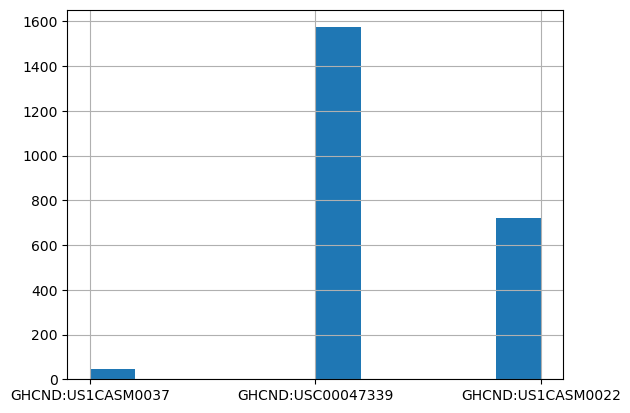

In [236]:
df_weather['station'].hist()

In [237]:
df_weather_wide = df_weather.loc[df_weather['station'] == 'GHCND:USC00047339'].pivot(columns='datatype', index='date', values=[ 'value'])
df_weather_wide.head()

value                    
datatype             PRCP   TMAX  TMIN   TOBS
date                                         
2021-01-01T00:00:00   0.0  156.0  22.0   83.0
2021-01-02T00:00:00  13.0  122.0  78.0  106.0
2021-01-03T00:00:00   0.0  133.0  78.0  100.0
2021-01-04T00:00:00  56.0  156.0  61.0   67.0
2021-01-05T00:00:00   0.0  133.0  39.0   56.0

In [238]:
df_weather_wide = df_weather.loc[df_weather['station'] == 'GHCND:USC00047339'].pivot_table(values=['value'], index='date', columns='datatype')
df_weather_wide.head()

value                    
datatype             PRCP   TMAX  TMIN   TOBS
date                                         
2021-01-01T00:00:00   0.0  156.0  22.0   83.0
2021-01-02T00:00:00  13.0  122.0  78.0  106.0
2021-01-03T00:00:00   0.0  133.0  78.0  100.0
2021-01-04T00:00:00  56.0  156.0  61.0   67.0
2021-01-05T00:00:00   0.0  133.0  39.0   56.0

In [239]:
df_weather_wide.info()

<class 'pandas.core.frame.DataFrame'>
Index: 396 entries, 2021-01-01T00:00:00 to 2022-01-31T00:00:00
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   (value, PRCP)  390 non-null    float64
 1   (value, TMAX)  396 non-null    float64
 2   (value, TMIN)  394 non-null    float64
 3   (value, TOBS)  394 non-null    float64
dtypes: float64(4)
memory usage: 15.5+ KB


In [245]:
df_weather_wide.reset_index(inplace=True)

In [241]:
df_weather_wide.columns = df_weather_wide.columns.get_level_values(1)

In [246]:
df_weather_wide.head()

datatype                 date  PRCP   TMAX  TMIN   TOBS
0         2021-01-01T00:00:00   0.0  156.0  22.0   83.0
1         2021-01-02T00:00:00  13.0  122.0  78.0  106.0
2         2021-01-03T00:00:00   0.0  133.0  78.0  100.0
3         2021-01-04T00:00:00  56.0  156.0  61.0   67.0
4         2021-01-05T00:00:00   0.0  133.0  39.0   56.0

In [250]:
df_weather_wide['date'] = pd.to_datetime(df_weather_wide['date'])

In [251]:
df_weather_wide.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 396 entries, 0 to 395
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    396 non-null    datetime64[ns]
 1   PRCP    390 non-null    float64       
 2   TMAX    396 non-null    float64       
 3   TMIN    394 non-null    float64       
 4   TOBS    394 non-null    float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 15.6 KB


In [256]:
df_weather_wide.set_index('date', inplace=True)

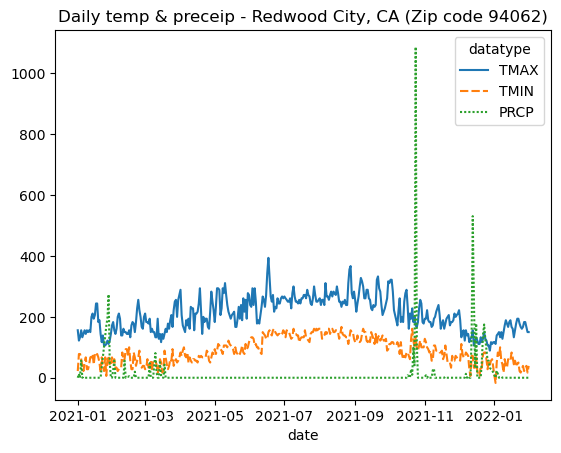

In [257]:
sns.lineplot(data=df_weather_wide[['TMAX', 'TMIN', 'PRCP']])
plt.title('Daily temp & preceip - Redwood City, CA (Zip code 94062)')
plt.show()

In [258]:
df_weather_wide_st2 = df_weather.loc[df_weather['station'] == 'GHCND:US1CASM0022'].pivot(columns='datatype', index='date', values=[ 'value'])
df_weather_wide_st2.head()

value                 
datatype    DAPR   MDPR PRCP SNOW
date                             
2021-01-05   5.0  157.0  NaN  NaN
2021-01-06   NaN    NaN  0.0  0.0
2021-01-07   NaN    NaN  0.0  0.0
2021-01-08   NaN    NaN  8.0  NaN
2021-01-09   NaN    NaN  0.0  0.0

In [212]:
# Fetch Daily Summary data from zip code - Redwood City, CA
dataset = 'data'
params = {'datasetid':'GHCND', 'startdate':'2021-01-01', 'enddate':'2022-01-31', 'locationid':'ZIP:94305', 'limit':'1000'}
r = requests.get(urlbase + dataset, headers=headers, params=params)
r.json()

{}